In [1]:
from math import cos, sin, acos, asin, atan2, sqrt, pi
from numpy import genfromtxt
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist

# from std_msgs.msg import Float64
# from geometry_msgs.msg import Twist
# from nav_msgs.msg import Odometry

from coursework_2.map import generate_map, expand_map, DENIRO_width
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import rospy
import sys

In [303]:
deniro_position = np.array([0, -6.0])
deniro_heading = 0.0
deniro_linear_vel = 0.0
deniro_angular_vel = 0.0

map = generate_map()

initial_position = np.array([0.0, -6.0])
goal = np.array([8.0, 8.0])


def deniro_odom_callback(msg):
    global deniro_position, deniro_heading, deniro_linear_vel, deniro_angular_vel
    deniro_position = np.array([msg.pose.pose.position.x, msg.pose.pose.position.y])
    r = R.from_quat([msg.pose.pose.orientation.x,
                     msg.pose.pose.orientation.y,
                     msg.pose.pose.orientation.z,
                     msg.pose.pose.orientation.w])
    deniro_heading = r.as_euler('xyz')[2]
    deniro_linear_vel = np.sqrt(msg.twist.twist.linear.x ** 2 + msg.twist.twist.linear.y ** 2)
    deniro_angular_vel = msg.twist.twist.angular.z


def set_vref_publisher():
    # rospy.init_node("motion_planning_node")

    wait = True
    while(wait):
        # now = rospy.Time.now()
        if now.to_sec() > 0:
            wait = False

    vref_topic_name = "/robot/diff_drive/command"
    #rostopic pub /robot/diff_drive/command geometry_msgs/Twist -r 10 -- '[0.0, 0.0, 0.0]' '[0.0, 0.0, -0.5]'
    # pub = rospy.Publisher(vref_topic_name, Twist, queue_size=1000)
    
    odom_topic_name = "odom"
    # sub = rospy.Subscriber(odom_topic_name, Odometry, deniro_odom_callback)
    return pub


def cmd_vel_2_twist(v_forward, omega):
    twist_msg = Twist()
    twist_msg.linear.x = v_forward
    twist_msg.linear.y = 0
    twist_msg.linear.z = 0
    twist_msg.angular.x = 0
    twist_msg.angular.y = 0
    twist_msg.angular.z = omega
    return twist_msg


class MotionPlanner():
    
    def __init__(self, map, scale, goal):
        # self.vref_publisher = set_vref_publisher()
        self.pixel_map = map
        self.xscale, self.yscale = scale
        self.goal = goal
    
    def send_velocity(self, vref):
        # vref is given in cartesian coordinates (v_x, v_y)
        # DE NIRO is driven in linear and angular coordinates (v_forward, omega)
        #print("px:\t", deniro_position[0], ",\tpy:\t", deniro_position[1])
        #print("gx:\t", goal[0], ",\tgy:\t", goal[1])
        print("vx:\t", vref[0], ",\tvy:\t", vref[1])
        v_heading = atan2(vref[1], vref[0])
        heading_error = deniro_heading - v_heading
        omega = 1 * heading_error
        # only drive forward if DE NIRO is pointing in the right direction
        if abs(heading_error) < 0.1:
            v_forward = min(max(sqrt(vref[0]**2 + vref[1]**2), 0.1), 0.2)
        else:
            v_forward = 0
        
        twist_msg = cmd_vel_2_twist(v_forward, omega)
        print("v_fwd:\t", v_forward, ",\tw:\t", omega)
        
        self.vref_publisher.publish(twist_msg)
        
    def map_position(self, world_position):
        world_position = world_position.reshape((-1, 2))
        map_x = np.rint(world_position[:, 0] * self.xscale + self.pixel_map.shape[0] / 2)
        map_y = np.rint(world_position[:, 1] * self.yscale + self.pixel_map.shape[1] / 2)
        map_position = np.vstack((map_x, map_y)).T
        return map_position
    
    def world_position(self, map_position):
        map_position = map_position.reshape((-1, 2))
        world_x = (map_position[:, 0] - self.pixel_map.shape[0] / 2) / self.xscale
        world_y = (map_position[:, 1] - self.pixel_map.shape[1] / 2) / self.yscale
        world_position = np.vstack((world_x, world_y)).T
        return world_position
    
    # def run_planner(self, planning_algorithm):
    #     rate = rospy.Rate(25)
    #     while not rospy.is_shutdown():
    #         vref, complete = planning_algorithm()
    #         self.send_velocity(vref)
    #         if complete:
    #             print("Completed motion")
    #             break
    #         rate.sleep()
    
    def setup_waypoints(self):
        ############################################################### TASK B
        # Create an array of waypoints for the robot to navigate via to reach the goal
        waypoints = np.array([[0.0, -3],
                              [2.5, -3],
                              [2.5, 8.0]])  # fill this in with your waypoints

        waypoints = np.vstack([initial_position, waypoints, self.goal])
        pixel_goal = self.map_position(self.goal)
        pixel_waypoints = self.map_position(waypoints)
        
        print('Waypoints:\n', waypoints)
        # print('Waypoints in pixel coordinates:\n', pixel_waypoints)
        
        # Plotting
        # plt.imshow(self.pixel_map, vmin=0, vmax=1, origin='lower')
        # plt.scatter(pixel_waypoints[:, 0], pixel_waypoints[:, 1])
        # plt.plot(pixel_waypoints[:, 0], pixel_waypoints[:, 1])
        # plt.show()
        
        self.waypoints = waypoints
        self.waypoint_index = 0
    
    def waypoint_navigation(self):
        complete = False
        
        # get the current waypoint
        current_waypoint = self.waypoints[self.waypoint_index, :]
        # calculate the vector from DE NIRO to waypoint
        waypoint_vector = current_waypoint - deniro_position
        # calculate the distance from DE NIRO to waypoint
        distance_to_waypoint = np.linalg.norm(waypoint_vector)
        # calculate the unit direction vector from DE NIRO to waypoint
        waypoint_direction = waypoint_vector / distance_to_waypoint
        
        # Calculate a reference velocity based on the direction of the waypoint
        vref = waypoint_direction * 0.5
        
        # If we have reached the waypoint, start moving to the next waypoint
        if distance_to_waypoint < 0.05:
            self.waypoint_index += 1    # increase waypoint index
            
        # If we have reached the last waypoint, stop
        if self.waypoint_index > self.waypoints.shape[0]:
            vref = np.array([0, 0])
            complete = True
        return vref, complete

    def potential_field(self):
        ############################################################### TASK C
        complete = False
        
        # compute the positive force attracting the robot towards the goal
        # vector to goal position from DE NIRO
        goal_vector = goal - self.deniro_position
        # distance to goal position from DE NIRO
        distance_to_goal = np.linalg.norm(goal_vector)
        # unit vector in direction of goal from DE NIRO
        pos_force_direction = goal_vector / distance_to_goal
        
        # potential function
        pos_force_magnitude = 1.0     # your code here!
        # tuning parameter
        K_att = 1.0     # tune this parameter to achieve desired results
        
        # positive force
        positive_force = K_att * pos_force_direction * pos_force_magnitude  # normalised positive force
        
        # compute the negative force repelling the robot away from the obstacles
        obstacle_pixel_locations = np.argwhere(self.pixel_map == 1)
        # coordinates of every obstacle pixel
        obstacle_pixel_coordinates = np.array([obstacle_pixel_locations[:, 1], obstacle_pixel_locations[:, 0]]).T
        # coordinates of every obstacle pixel converted to world coordinates
        obstacle_positions = self.world_position(obstacle_pixel_coordinates)
        
        # vector to each obstacle from DE NIRO
        obstacle_vector = obstacle_positions - self.deniro_position   # vector from DE NIRO to obstacle
        # distance to obstacle from DE NIRO
        distance_to_obstacle = np.linalg.norm(obstacle_vector, axis=1).reshape((-1, 1))  # magnitude of vector
        # unit vector in direction of obstacle from DE NIRO
        force_direction = obstacle_vector / distance_to_obstacle   # normalised vector (for direction)
        
        # potential function
        force_magnitude = 1.0 / (distance_to_obstacle * distance_to_obstacle)   # your code here!
        # tuning parameter
        K_rep = -40.0     # tune this parameter to achieve desired results
        
        # force from an individual obstacle pixel
        obstacle_force = force_direction * force_magnitude
        # total negative force on DE NIRO
        negative_force = K_rep * np.sum(obstacle_force, axis=0) / obstacle_pixel_locations.shape[0]
        
        
        # Uncomment these lines to visualise the repulsive force from each obstacle pixel
        # Make sure to comment it out again when you run the motion planner fully
        # plotskip = 10   # only plots every 10 pixels (looks cleaner on the plot)
        # plt.imshow(self.pixel_map, vmin=0, vmax=1, origin='lower')
        # plt.quiver(obstacle_pixel_coordinates[::plotskip, 0], obstacle_pixel_coordinates[::plotskip, 1],
        #               obstacle_force[::plotskip, 0] * self.xscale, obstacle_force[::plotskip, 1] * self.yscale)
        # plt.show()

        #print("positive_force:", positive_force)
        #print("negative_force:", negative_force)
        
        # Reference velocity is the resultant force
        vref = positive_force + negative_force
        
        # If the goal has been reached, stop
        if distance_to_goal < 0.05:
            vref = np.array([0, 0])
            complete = True
        return vref, complete, positive_force, negative_force
    
    def generate_random_points(self, N_points):
        ############################################################### TASK D
        N_accepted = 0  # number of accepted samples
        accepted_points = np.empty((1, 2))  # empty array to store accepted samples
        rejected_points = np.empty((1, 2))  # empty array to store rejected samples
        
        while N_accepted < N_points:    # keep generating points until N_points have been accepted
        
            points = np.random.uniform(-10, 10, (N_points - N_accepted, 2))  # generate random coordinates
            pixel_points = self.map_position(points)    # get the point locations on our map
            rejected = np.zeros(N_points - N_accepted)   # create an empty array of rejected flags
            
            # Your code here!
            # Loop through the generated points and check if their pixel location corresponds to an obstacle in self.pixel_map
            # self.pixel_map[px_y, px_x] = 1 when an obstacle is present
            rejected = self.pixel_map[pixel_points[:, 1].astype(int), pixel_points[:, 0].astype(int)] == 1
            # Remember that indexing a 2D array is [row, column], which is [y, x]!
            # You might have to make sure the pixel location is an integer so it can be used to index self.pixel_map
                
            new_accepted_points = pixel_points[np.argwhere(rejected == 0)].reshape((-1, 2))
            new_rejected_points = pixel_points[np.argwhere(rejected == 1)].reshape((-1, 2))
            # keep an array of generated points that are accepted
            accepted_points = np.vstack((accepted_points, new_accepted_points))
            # keep an array of generated points that are rejected (for visualisation)
            rejected_points = np.vstack((rejected_points, new_rejected_points))
            N_accepted = accepted_points.shape[0] - 1     
        
        # throw away that first 'empty' point we added for initialisation
        accepted_points = accepted_points[1:, :]
        rejected_points = rejected_points[1:, :]   
        
        # visualise the accepted and rejected points
        plt.imshow(self.pixel_map, vmin=0, vmax=1, origin='lower')  # setup a plot of the map
        
        plt.scatter(accepted_points[:, 0], accepted_points[:, 1], c='b')    # plot accepted points in blue
        plt.scatter(rejected_points[:, 0], rejected_points[:, 1], c='r')    # plot rejected points in red
        
        deniro_pixel = self.map_position(initial_position)
        goal_pixel = self.map_position(goal)
        plt.scatter(deniro_pixel[0, 0], deniro_pixel[0, 1], c='w')  # plot DE NIRO as a white point
        plt.scatter(goal_pixel[0, 0], goal_pixel[0, 1], c='g')  # plot the goal as a green point
        
        plt.show()
        
        world_points = self.world_position(accepted_points) # calculate the position of the accepted points in world coordinates
        world_points = np.vstack((initial_position, world_points, goal))    # add DE NIRO's position to the beginning of these points, and the goal to the end
        
        return world_points
    
    def create_graph(self, points):
        ############################################################### TASK E i
        # Choose your minimum and maximum distances to produce a suitable graph
        mindist = 1.0
        maxdist = 3.0
        
        # Calculate a distance matrix between every node to every other node
        distances = cdist(points, points)
        
        # Create two dictionaries
        graph = {}  # dictionary of each node, and the nodes it connects to
        distances_graph = {}    # dictionary of each node, and the distance to each node it connects to
        
        plt.imshow(self.pixel_map, vmin=0, vmax=1, origin='lower')  # setup a plot of the map
        
        for i in range(points.shape[0]):    # loop through each node
            points_in_range = points[(distances[i] >= mindist) & (distances[i] <= maxdist)]     # get nodes an acceptable distance of the current node
            distances_in_range = distances[i, (distances[i] >= mindist) & (distances[i] <= maxdist)]    # get the corresponding distances to each of these nodes
            
            if points_in_range.shape[0] > 0:    # if there are any nodes in an acceptable range
            
                # set up arrays of nodes with edges that don't collide with obstacles, and their corresponding distances
                collision_free_points = np.empty((1, 2))
                collision_free_distances = np.empty((1, 1))
                
                for j in range(points_in_range.shape[0]):   # loop through the nodes an acceptable distance of the current node
                
                    pxA = self.map_position(points[i])  # get the current node position on the map
                    pxB = self.map_position(points_in_range[j])     # get the node in range position on the map

                    collision = self.check_collisions(points[i], points_in_range[j])    # check if there is a collision on the edge between two points
                    
                    if collision:
                        # if there is a collision, plot the edge in red
                        plt.plot([pxA[0, 0], pxB[0, 0]], [pxA[0, 1], pxB[0, 1]], c='r')
                        pass
                    else:
                        # if there is no collision, add the node in range to the array of nodes that have no collisions
                        collision_free_points = np.append(collision_free_points, points_in_range[j].reshape((1, 2)), axis=0)
                        # add the corresponding distance to the array of distances
                        collision_free_distances = np.append(collision_free_distances, distances_in_range[j].reshape((1, 1)))
                        # plot the edge in blue
                        plt.plot([pxA[0, 0], pxB[0, 0]], [pxA[0, 1], pxB[0, 1]], c='b')
                        
                # after we've looped through every point, update the two dictionaries
                graph[str(points[i])] = collision_free_points[1:]
                distances_graph[str(points[i])] = collision_free_distances[1:]
                
        # Plotting
        deniro_pixel = self.map_position(initial_position)
        goal_pixel = self.map_position(goal)
        
        plt.scatter(deniro_pixel[0, 0], deniro_pixel[0, 1], c='w')
        plt.scatter(goal_pixel[0, 0], goal_pixel[0, 1], c='g')
        
        plt.show()
        
        return graph, distances_graph
    
    def check_collisions(self, pointA, pointB):
        ############################################################### TASK E ii   
        # Create a vector from A to B
        vectorAB = np.array(pointB) - np.array(pointA)
        # Calculate the distance between the two points
        distance = np.linalg.norm(vectorAB)
        # Calculate the UNIT direction vector pointing from pointA to pointB
        direction = vectorAB / distance
        # Choose a resolution for collision checking
        resolution = 0.05   # resolution to check collision to in m
        
        # Create an array of points to check collisions at
        edge_points = pointA.reshape((1, 2)) + np.arange(0, distance, resolution).reshape((-1, 1)) * direction.reshape((1, 2))
        # Convert the points to pixels
        edge_pixels = self.map_position(edge_points)
        
        for pixel in edge_pixels:   # loop through each pixel between pointA and pointB
            collision = self.pixel_map[int(pixel[1]), int(pixel[0])]    # if the pixel collides with an obstacle, the value of the pixel map is 1
            if collision == 1:
                return True     # if there's a collision, immediately return True
        return False    # if it's got through every pixel as hasn't returned yet, return False
    
    def dijkstra(self, graph, edges):
        ############################################################### TASK F
        goal_node = goal
        nodes = list(graph.keys())
        
        # Create a dataframe of unvisited nodes
        # Initialise each cost to a very high number
        initial_cost = 10000.0  # Set this to a suitable value
        
        unvisited = pd.DataFrame({'Node': nodes, 'Cost': [initial_cost for node in nodes], 'Previous': ['' for node in nodes]})
        unvisited.set_index('Node', inplace=True)
        # Set the first node's cost to zero
        unvisited.loc[[str(initial_position)], ['Cost']] = 0.0
        
        # Create a dataframe of visited nodes (it's empty to begin with)
        visited = pd.DataFrame({'Node':[''], 'Cost':[0.0], 'Previous':['']})
        visited.set_index('Node', inplace=True)
        
        # Take a look at the initial dataframes
        print('--------------------------------')
        print('Unvisited nodes')
        print(unvisited.head())
        print('--------------------------------')
        print('Visited nodes')
        print(visited.head())
        print('--------------------------------')
        print('Running Dijkstra')
        
        # Dijkstra's algorithm!
        # Keep running until we get to the goal node
        while str(goal_node) not in visited.index.values:
            
            # Go to the node that is the minimum distance from the starting node
            current_node = unvisited[unvisited['Cost']==unvisited['Cost'].min()]
            current_node_name = current_node.index.values[0]    # the node's name (string)
            current_cost = current_node['Cost'].values[0]       # the distance from the starting node to this node (float)
            current_tree = current_node['Previous'].values[0]   # a list of the nodes visited on the way to this one (string)
            
            connected_nodes = graph[current_node.index.values[0]]   # get all of the connected nodes to the current node (array)
            connected_edges = edges[current_node.index.values[0]]   # get the distance from each connected node to the current node   
            
            # Loop through all of the nodes connected to the current node
            for next_node_name, edge_cost in zip(connected_nodes, connected_edges):
                next_node_name = str(next_node_name)    # the next node's name (string)
                
                if next_node_name not in visited.index.values:  # if we haven't visited this node before
                    #print(unvisited)
                    #print(np.array( np.array(current_node).astype(float) - np.array(next_node_name).astype(float) ))
                    
                    #print(np.array(next_node_name))
                    # update this to calculate the cost of going from the initial node to the next node via the current node
                    next_cost_trial = current_cost + 1.0  # set this to calculate the cost of going from the initial node to the next node via the current node
                    next_cost = unvisited.loc[[next_node_name], ['Cost']].values[0] # the previous best cost we've seen going to the next node
                    
                    # if it costs less to go the next node from the current node, update then next node's cost and the path to get there
                    if next_cost_trial < next_cost:
                        unvisited.loc[[next_node_name], ['Cost']] = next_cost_trial
                        unvisited.loc[[next_node_name], ['Previous']] = current_tree + current_node_name    # update the path to get to that node
            
            unvisited.drop(current_node_name, axis=0, inplace=True)     # remove current node from the unvisited list

            visited.loc[current_node_name] = [current_cost, current_tree]   # add current node to the visited list
            
        print('--------------------------------')
        print('Unvisited nodes')
        print(unvisited.head())
        print('--------------------------------')
        print('Visited nodes')
        print(visited.head())
        print('--------------------------------')
        
        optimal_cost = visited.loc[[str(goal_node)], ['Cost']].values[0][0]  # Optimal cost (float)
        optimal_path = visited.loc[[str(goal_node)], ['Previous']].values[0][0]  # Optimal path (string)
        
        # Convert the optimal path from a string to an actual array of waypoints to travel to
        string_waypoints = optimal_path[1:-1].split('][')
        optimal_waypoints = np.array([np.fromstring(waypoint, sep=' ') for waypoint in string_waypoints])
        optimal_waypoints = np.vstack((optimal_waypoints, goal))    # add the goal as the final waypoint
        
        print('Results')
        print('Goal node: ', str(goal_node))
        print('Optimal cost: ', optimal_cost)
        print('Optimal path:\n', optimal_waypoints)
        print('--------------------------------')
        
        # Plotting
        optimal_pixels = self.map_position(optimal_waypoints)
        plt.plot(optimal_pixels[:, 0], optimal_pixels[:, 1], c='b')
        
        deniro_pixel = self.map_position(initial_position)
        goal_pixel = self.map_position(goal)
        
        plt.imshow(self.pixel_map, vmin=0, vmax=1, origin='lower')
        plt.scatter(deniro_pixel[0, 0], deniro_pixel[0, 1], c='w')
        plt.scatter(goal_pixel[0, 0], goal_pixel[0, 1], c='g')
        
        plt.show()
        
        # Setup the waypoints for normal waypoint navigation
        self.waypoints = optimal_waypoints
        self.waypoint_index = 0
        
        
def main(task):
    # load the map and expand it
    img, xscale, yscale = generate_map()
    c_img = expand_map(img, DENIRO_width)
    
    # load the motion planner
    planner = MotionPlanner(c_img, (xscale, yscale), goal=goal)
    
    if task == 'waypoints':
        print("============================================================")
        print("Running Waypoint Navigation")
        print("------------------------------------------------------------")
        planner.setup_waypoints()
        planner.run_planner(planner.waypoint_navigation)
        
    elif task == 'potential':
        print("============================================================")
        print("Running Potential Field Algorithm")
        print("------------------------------------------------------------")
        planner.run_planner(planner.potential_field)
    
    elif task == 'prm':
        print("============================================================")
        print("Running Probabilistic Road Map")
        print("------------------------------------------------------------")
        points = planner.generate_random_points(N_points=100)
        graph, edges = planner.create_graph(points)
        planner.dijkstra(graph, edges)
        planner.run_planner(planner.waypoint_navigation)

## Load planner and map

In [3]:
img, xscale, yscale = generate_map()
c_img = expand_map(img, DENIRO_width)

xmin = -10.1
xmax = 10.1
ymin = -10.1
ymax = 10.1

map_extent = (xmin, xmax, ymax, ymin)

# load the motion planner
planner = MotionPlanner(c_img, (xscale, yscale), goal=goal)

def reload_planner():
    global planner
    planner = MotionPlanner(c_img, (xscale, yscale), goal=goal)
    
def plot_map():
    plt.imshow(c_img, extent = map_extent, cmap="Greys")

def plot_path(waypoints):
    plt.plot(waypoints[:, 0], waypoints[:, 1], color = "orange")
    plt.scatter(waypoints[:, 0], waypoints[:, 1], color = "orange")

## Waypoints

Waypoints:
 [[ 0.  -6. ]
 [ 0.  -3. ]
 [ 2.5 -3. ]
 [ 2.5  8. ]
 [ 8.   8. ]]


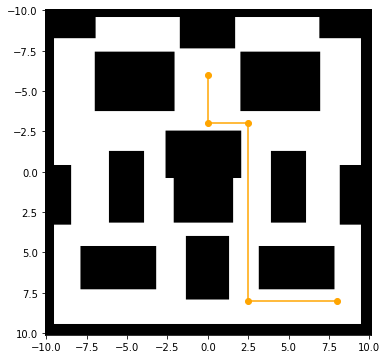

In [4]:
reload_planner()

# Generate waypoints
planner.setup_waypoints()

# Plot waypoints
plt.figure(figsize = (6, 6))

plot_map()
plot_path(planner.waypoints)

## Potential field

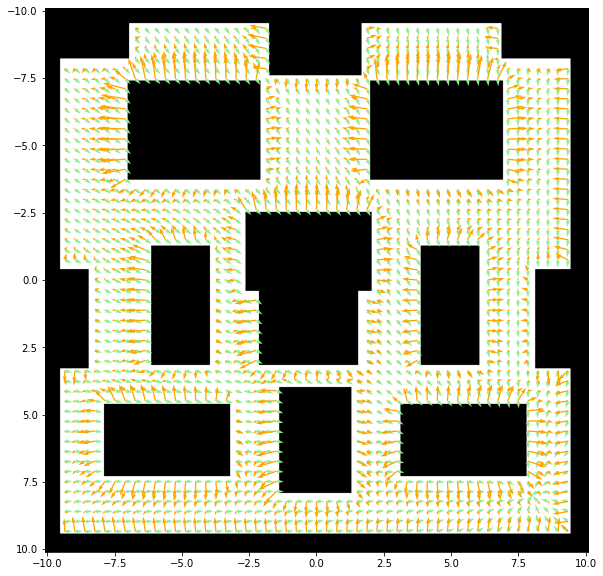

In [112]:
reload_planner()

# Plot repulsion
plt.figure(figsize = (10, 10))

X = []
Y = []
POS = []
NEG = []

for y in np.linspace(xmin, xmax, 55):
    for x in np.linspace(ymin, ymax, 55):
        planner.deniro_position = np.array([x, y])
        vref, complete, pos, neg = planner.potential_field()
        
        # If we are not inside an obsticle
        if(c_img[min(int(y * yscale + (c_img.shape[0] / 2)), 322), min(int(x * yscale + (c_img.shape[1] / 2)), 322)] == 0):
            X.append(x)
            Y.append(y)
            POS.append(pos)
            NEG.append(neg)

POS = np.array(POS)
NEG = np.array(NEG)
        
plot_map()
plt.quiver(X, Y, POS[:, 0], -POS[:, 1], color = "lightgreen")
plt.quiver(X, Y, NEG[:, 0], -NEG[:, 1], color = "orange")

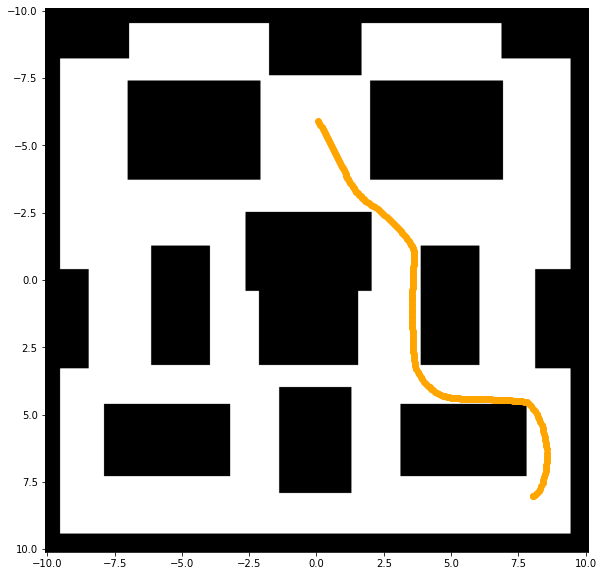

In [121]:
reload_planner()

dt = 0.1

planner.deniro_position = np.copy(initial_position)

PATH = []

for t in np.arange(0, 30, dt):
    vref, done = planner.potential_field()[:2]
    
    planner.deniro_position += vref * dt
    
    PATH.append(np.copy(planner.deniro_position))
    
    if done:
        break
        print("reached goal")
    
PATH = np.array(PATH)
    
    
# Plot repulsion
plt.figure(figsize = (10, 10))

plot_map()
plot_path(PATH)

## PRM

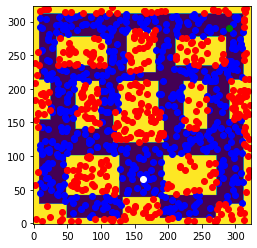

In [305]:
reload_planner()

# Test generating random points
points = planner.generate_random_points(500)

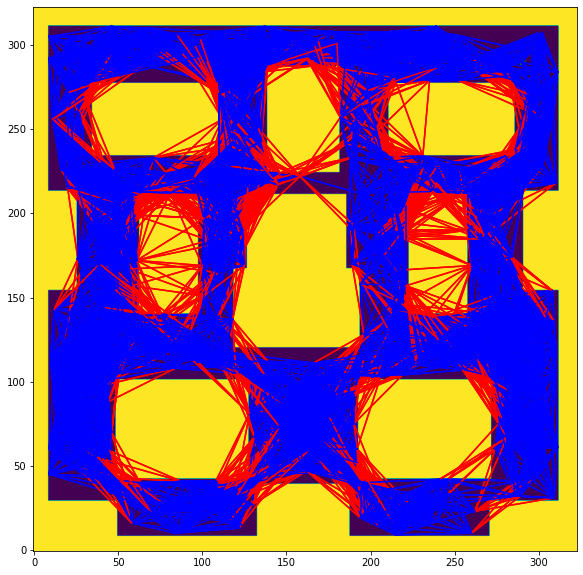

In [306]:
reload_planner()

plt.figure(figsize = (10, 10))

graph, edges = planner.create_graph(points)

# # Plot repulsion
# plt.figure(figsize = (10, 10))

# print(distances_graph)

# plot_map()
# for edge in edges:
#     print(edge)
#     # plt.plot([edge[0], edge[0]], [edge[0, 1], edge[0, 1]], c='b')

## Dijkstra's

--------------------------------
Unvisited nodes
                        Cost Previous
Node                                 
[ 0. -6.]                0.0         
[-9.28125  5.96875]  10000.0         
[-2.71875  5.90625]  10000.0         
[-2.71875  5.15625]  10000.0         
[ 8.21875 -1.84375]  10000.0         
--------------------------------
Visited nodes
      Cost Previous
Node               
       0.0         
--------------------------------
Running Dijkstra
--------------------------------
Unvisited nodes
                     Cost                                           Previous
Node                                                                        
[-6.90625  8.96875]   8.0  [ 0. -6.][-1.53125 -3.59375][-3.40625 -2.84375...
[-7.21875  9.34375]   8.0  [ 0. -6.][-1.53125 -3.59375][-3.40625 -2.84375...
[-7.65625  7.34375]   8.0  [ 0. -6.][-1.53125 -3.59375][-3.40625 -2.84375...
[-6.71875  8.90625]   8.0  [ 0. -6.][-1.53125 -3.59375][-3.40625 -2.84375...
[-6.59375  8.2812

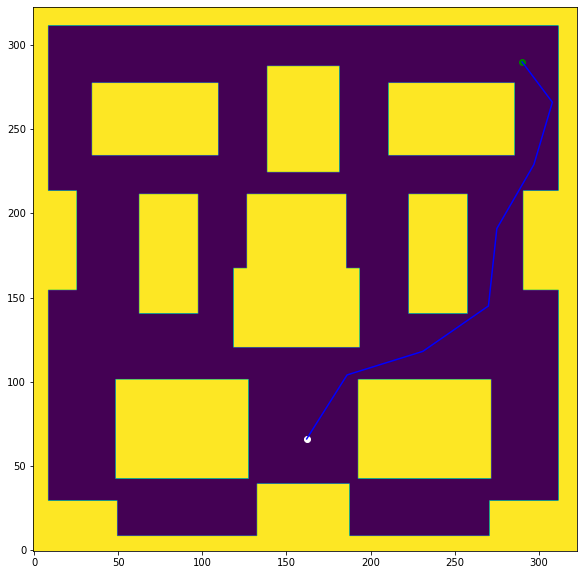

In [307]:
reload_planner()


plt.figure(figsize = (10, 10))
planner.dijkstra(graph, edges)